<a href="https://colab.research.google.com/github/UmarIgan/timeseries-notebooks/blob/main/glounts_hello.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gluonts
!pip install mxnet
!pip install pandas

     |████████████████████████████████| 2.8 MB 5.1 MB/s 
     |████████████████████████████████| 10.9 MB 40.3 MB/s 
     |████████████████████████████████| 47.3 MB 93 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


## Hello world gluonts
See https://www.microprediction.com/blog/popular-timeseries-packages for more packages

In [3]:
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.dataset import common
from gluonts.dataset.util import to_pandas
from gluonts.evaluation.backtest import make_evaluation_predictions
import pandas as pd
import requests
from itertools import islice
from dateutil.relativedelta import  *
from datetime import date, timedelta
import json
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [4]:
def load_bitcoin(period=180):
    coindeskURL = 'https://api.coindesk.com/v1/bpi/historical/close.json?'
    end = date.today()
    start = end - timedelta(days=period)
    url = f'{coindeskURL}start={start:%Y-%m-%d}&end={end:%Y-%m-%d}'
    result = requests.get(url)
    data=json.loads(result.content)['bpi']
    df_bpi=pd.DataFrame(data, index=[0]).T
    df_bpi=df_bpi.reset_index()
    df_bpi.columns=['date', 'value']
    df_bpi.sort_values(by='date')
    df_bpi['date']=pd.to_datetime(df_bpi['date'])
    df_bpi.set_index('date', inplace=True)
    return df_bpi
df_bitcoin=load_bitcoin(period=4000)

In [5]:
training_data = common.ListDataset([{
    "start": df_bitcoin.index[0],
    "target": df_bitcoin.value[:'2019-07-27']
}], freq='D')

test_data = common.ListDataset(
    [ {"start": df_bitcoin.index[0], "target": df_bitcoin.value[:'2021-07-27']},
     {"start": df_bitcoin.index[0], "target": df_bitcoin.value[:'2022-04-20']}],
    freq = "D"
)



def gluont_ts(training_data):
  trainer = Trainer(epochs=5)
  estimator = deepar.DeepAREstimator(prediction_length=100, trainer=trainer,
                                   freq='D')
  predictor = estimator.train(training_data=training_data)
  prediction = next(predictor.predict(training_data))
  return prediction


In [6]:
predictor=gluont_ts(training_data)
prediction=next(predictor.predict(test_data))

100%|██████████| 50/50 [00:15<00:00,  3.26it/s, epoch=10/10, avg_epoch_loss=4.01]


gluonts.model.forecast.SampleForecast(freq="D", info=None, item_id=None, samples=numpy.array([[38825.34375, 38681.30859375, 40115.171875, 42630.796875, 43226.63671875, 40295.8515625, 41647.50390625, 40484.97265625, 42103.08984375, 43037.04296875, 40997.734375, 39166.6953125, 45098.80078125, 41310.91796875, 52785.3203125, 46750.23828125, 45041.3359375, 47524.81640625, 47289.5625, 48701.546875, 46253.48828125, 45610.671875, 47961.1484375, 47768.33984375, 48868.2421875, 49278.03125, 50042.21484375, 50016.9140625, 52275.109375, 51581.55859375, 50372.61328125, 52348.1953125, 52781.74609375, 52859.5, 50032.9609375, 53997.74609375, 49720.16015625, 50212.8203125, 51976.26953125, 55658.95703125, 55540.5625, 45694.796875, 49701.26171875, 54602.8046875, 54736.89453125, 54753.6484375, 53128.6953125, 53719.95703125, 53318.3125, 54851.96875, 50988.015625, 53762.46484375, 51292.84765625, 57052.875, 55456.109375, 57881.25390625, 56088.61328125, 54173.53125, 55783.20703125, 53047.98828125, 53350.613281

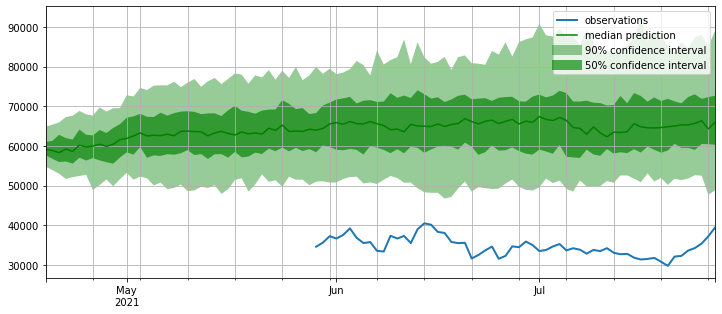

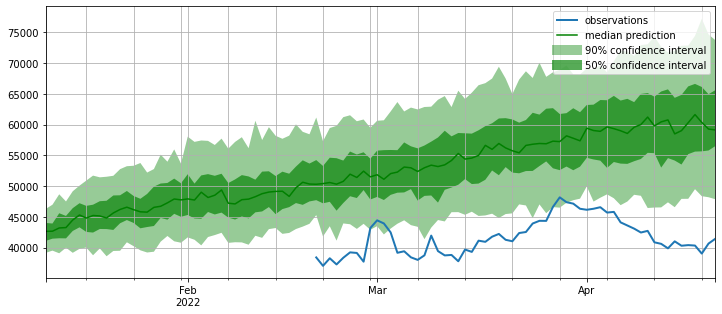

In [9]:
def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_data, predictor=predictor)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=60, num_plots=3)

In [10]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5])

agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

agg_metrics

Running evaluation: 100%|██████████| 2/2 [00:00<00:00, 64.23it/s]


{'Coverage[0.5]': 0.99,
 'MAE_Coverage': 0.49,
 'MAPE': 0.46140201568603517,
 'MASE': 110.6560449924318,
 'MSE': 416795136.0,
 'MSIS': 1574.6728217700093,
 'ND': 0.42154176367150087,
 'NRMSE': 0.4985032767798833,
 'OWA': nan,
 'QuantileLoss[0.5]': 3452740.1640625,
 'RMSE': 20415.561123809457,
 'abs_error': 3452740.25,
 'abs_target_mean': 40953.715,
 'abs_target_sum': 8190743.0,
 'mean_absolute_QuantileLoss': 3452740.1640625,
 'mean_wQuantileLoss': 0.42154175317947346,
 'sMAPE': 0.3483364391326904,
 'seasonal_error': 179.3474331514547,
 'wQuantileLoss[0.5]': 0.42154175317947346}